In [1]:
from pytorch_lightning import Trainer
import catinous.CatsinomModelGramCache_BrainAge as braincatsmodel
#import catinous.CatsinomModelGramCache as catsmodel
from catinous.CatsinomDataset import BrainAgeDataset
from catinous.CatsinomModelGramCache_BrainAge import CatsinomModelGramCacheBrainAge

from catinous import utils as cutils

import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
import os
import torchvision.models as models
import torch.nn as nn
import torch
import torch.nn.functional as F
import argparse
import pytorch_lightning as pl
import sklearn 
from sklearn.metrics import confusion_matrix, auc, roc_curve
import torch
import pandas as pd
import seaborn as sns
import pickle
from py_jotools import mut, slurm, cache
import numpy as np
import gc
import hashlib
import dill
import catinous.utils as cutils

from sklearn.metrics import mean_absolute_error
from catinous.AgePredictor import EncoderRegressor

%load_ext autoreload
%autoreload 


Bad key "text.kerning_factor" on line 4 in
/home/mperkonigg/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


# Base training

In [2]:
schedule = False

sparams = {
    'binary': '/home/cir/mperkonigg/env/catinous/bin/python',
    'cwd': '/home/cir/mperkonigg/catinous/catinous',
    'gpu': 1,
    'partition': 'full',
    'memory': 100000,
    'jobname': 'catinous_brain',
    'outputpath': '/home/cir/mperkonigg/slurmoutput/',
    'mailuser': 'matthias.perkonigg@meduniwien.ac.at',
    'minutes': '240'}

hparams={'continous':False,
         'datasetfile': '/project/catinous/brainds_split_val_test_balance.csv',
         'noncontinous_train_splits': ['base_train'],
         'noncontinous_steps': 4000,
         'root_dir': '',
         'batch_size': 4,
         'learning_rate': 0.0001}

if schedule:
    slurm.srun(braincatsmodel.trained_model, [hparams], params=sparams, remote=True)
else:
    model, logs, df_cache, basemodel_lr = braincatsmodel.trained_model(hparams)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = 

In [3]:
def test_model(model, ds, device):
    output = []
    target = []
    for data in ds:
        x, y, img, res = data
        x = x.float().to(device)
        y_out = model.forward(x)

        target.extend(y.detach().cpu().numpy())
        output.extend([o[0] for o in y_out.detach().cpu().numpy()])
        
        model.grammatrices = []
        
    return target, output

def plot_test_roc(model, datasets, device, mname=''):
    
    model.freeze()
    
    fig, ax = plt.subplots()    
    for ds in datasets:
        target, output = test_model(model, datasets[ds], device)
    
        #vu.plot_roc_curve(target, output, title= ds + ' Test (trained on ' + dsname + ' dataset)')
        fpr, tpr, threshold = roc_curve(target, output)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=ds + ' AUC = %0.2f' % roc_auc)
        
    ax.set_title(mname + ' Test')
    ax.legend(loc='lower right')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

In [10]:
device = torch.device('cuda')
model.to(device)
model.eval()
val_phil15 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split_val_test_balance.csv', split='val', res='1.5T Philips'), batch_size=4, num_workers=4)
val_phil30 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split_val_test_balance.csv', split='val', res='3.0T Philips'), batch_size=4, num_workers=4)
val_30 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split_val_test_balance.csv', split='val', res='3.0T'), batch_size=4, num_workers=4)

In [11]:
target, output = test_model(model, val_phil15, device)
print('phil 15', mean_absolute_error(target, output))
target, output = test_model(model, val_phil30, device)
print('phil 30', mean_absolute_error(target, output))
target, output = test_model(model, val_30, device)
print('30', mean_absolute_error(target, output))

phil 15 6.822156
phil 30 11.660595
30 12.11119


In [13]:
test_phil15 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split_val_test_balance.csv', split='test', res='1.5T Philips'), batch_size=4, num_workers=4)
test_phil30 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split_val_test_balance.csv', split='test', res='3.0T Philips'), batch_size=4, num_workers=4)
test_30 = DataLoader(BrainAgeDataset('/project/catinous/brainds_split_val_test_balance.csv', split='test', res='3.0T'), batch_size=4, num_workers=4)

target, output = test_model(model, test_phil15, device)
print('phil 15', mean_absolute_error(target, output))
target, output = test_model(model, test_phil30, device)
print('phil 30', mean_absolute_error(target, output))
target, output = test_model(model, test_30, device)
print('30', mean_absolute_error(target, output))

phil 15 7.1477857
phil 30 11.793578
30 13.304228


In [2]:
schedule = True

sparams = {
    'binary': '/home/cir/mperkonigg/env/catinous/bin/python',
    'cwd': '/home/cir/mperkonigg/catinous/catinous',
    'gpu': 1,
    'partition': 'centos7',
    'memory': 100000,
    'jobname': 'catinousbrains',
    'outputpath': '/home/cir/mperkonigg/slurmoutput/',
    'mailuser': 'matthias.perkonigg@meduniwien.ac.at',
    'minutes': '240'}

hparams={'continous': True,
         'use_cache':False,
         'random_cache': False,
         'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_887f3c1b44.pt',
        'val_check_interval': 40,
        'run_postfix': 2,
         'batch_size': 4,
        'cachemaximum': 32,
        'force_misclassified':True,
        'learning_rate': 0.000005}

if schedule:
    slurm.srun(braincatsmodel.trained_model, [hparams], params=sparams, remote=True)
else:
    model, logs, df_cache, basemodel_lr = braincatsmodel.trained_model(hparams)

catinousbrains96342
sshpass -f ~/.ssh/pass ssh cn1.cir.meduniwien.ac.at sbatch --export=NONE --partition centos7 /scratch/catinousbrains96342.job
Submitted batch job 3020172



In [21]:
def res_data_for_params(hparams):
    df = pd.DataFrame()
    base_params = []
    for i in range(5):
        base_params.append(hparams.copy())
        base_params[-1]['run_postfix'] = i+1
        if not braincatsmodel.is_cached(base_params[-1]):
            print('not cached')
            #slurm.srun(catsmodel.trained_model, [base_params[-1]], params=sparams, remote=True)    
        else:
            _, df_temp, _, _ = braincatsmodel.trained_model(base_params[-1])
            df_temp = df_temp.loc[df_temp['val_mae_1.5T Philips']==df_temp['val_mae_1.5T Philips']]
            df_temp['idx'] = range(1,len(df_temp)+1)
            df = df.append(df_temp)
    return df

In [82]:
hparams={'continous': True,
         'use_cache':True,
         'random_cache': True,
         'datasetfile': '/project/catinous/brainds_split.csv',
        'base_model': 'batch_brainds_split_base_train_1_887f3c1b44.pt',
        'val_check_interval': 40,
        'run_postfix': 2,
         'batch_size': 4,
        'cachemaximum': 32,
        'force_misclassified':True,
        'learning_rate': 0.000001}


res = cache.cache(res_data_for_params,hparams)

Load: /home/mperkonigg/zzz/__main__.res_data_for_params_0ba5ea39ef37da6f9377dd651ed937ac9f568e5c.p in: 0.00s


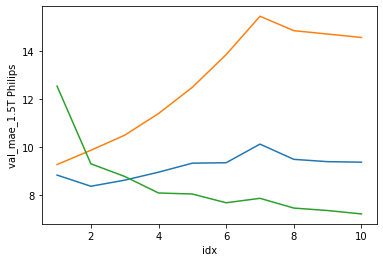

In [83]:
sns.lineplot(data=res, y='val_mae_1.5T Philips', x='idx', err_style=None)
sns.lineplot(data=res, y='val_mae_3.0T Philips', x='idx', err_style=None)
sns.lineplot(data=res, y='val_mae_3.0T', x='idx', err_style=None)

In [84]:
model, logs, df_cache, basemodel_lr = braincatsmodel.trained_model(hparams)

Read: /project/catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_cache_tf08_1_a3df085ecd.pt


In [64]:
state_dict = torch.load('/project/catinous/trained_models/cont_brainds_split_basemodel_brainds_fmiss_cache_tf08_1_5157838dd9_shift_1_ckpt.pt')
new_state_dict = dict()
for k in state_dict:
    new_state_dict[f'model.{k}'] = state_dict[k]

model.load_state_dict(new_state_dict)
model.eval()

CatsinomModelGramCacheBrainAge(
  (model): EncoderRegressor(
    (encoder): Encoder(
      (feature): Sequential(
        (f_conv1_1): Conv3d(1, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (f_relu_1_1): ReLU(inplace=True)
        (f_bn1_1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (f_conv1_2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (f_relu_1_2): ReLU(inplace=True)
        (f_bn1_2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (f_pool1): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (f_conv2_1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (f_relu_2_1): ReLU(inplace=True)
        (f_bn2_1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (f_conv2_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=

In [57]:
target, output = test_model(model, val_phil15, device)
print('phil 15', mean_absolute_error(target, output))
target, output = test_model(model, val_phil30, device)
print('phil 30', mean_absolute_error(target, output))
target, output = test_model(model, val_30, device)
print('30', mean_absolute_error(target, output))

phil 15 5.8263335
phil 30 10.068137
30 5.670698


In [85]:
target, output = test_model(model, val_phil15, device)
print('phil 15', mean_absolute_error(target, output))
target, output = test_model(model, val_phil30, device)
print('phil 30', mean_absolute_error(target, output))
target, output = test_model(model, val_30, device)
print('30', mean_absolute_error(target, output))

phil 15 5.9332795
phil 30 15.916748
30 5.606585


In [65]:
target, output = test_model(model, val_phil15, device)
print('phil 15', mean_absolute_error(target, output))
target, output = test_model(model, val_phil30, device)
print('phil 30', mean_absolute_error(target, output))
target, output = test_model(model, val_30, device)
print('30', mean_absolute_error(target, output))

phil 15 6.5418277
phil 30 11.346539
30 16.486118


In [2]:
hparams={'continous':False,
         'datasetfile': '/project/catinous/brainds_split.csv',
         'noncontinous_train_splits': ['base_train'],
         'noncontinous_steps': 4000,
         'root_dir': '',
         'batch_size': 4}

device = torch.device('cuda')

model = CatsinomModelGramCacheBrainAge(hparams=hparams, device=device)

#logger = cutils.pllogger(model.hparams)
trainer = Trainer(gpus=1, max_epochs=1, val_check_interval=model.hparams.val_check_interval, checkpoint_callback=False)
#trainer.fit(model)



GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [3]:
lr_finder = trainer.tuner.lr_find(model)


  | Name  | Type             | Params
-------------------------------------------
0 | model | EncoderRegressor | 2 M   
1 | loss  | MSELoss          | 0     
2 | mae   | L1Loss           | 0     
/home/mperkonigg/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


LR finder stopped early due to diverging loss.


/home/mperkonigg/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


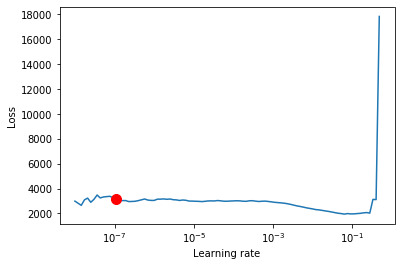

In [5]:
fig = lr_finder.plot(suggest=True)
fig.show()